# Cats VS Dogs 

Let's take Cats & Dogs again and see how we can improve our results with CNNs

* Import the libraries : 
  * Tensorflow 
  * Numpy 
  * Pandas 
  * Matplotlib.pyplot

In [ ]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

* Import dataset

In [ ]:
zip_file = tf.keras.utils.get_file("catsNdogs.zip", 
                                   "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   cache_subdir="/content",
                                   extract=True)

68608000/68606236 [==============================] - 0s 0us/step


* Training image path storage

In [ ]:
import pathlib 
train_set = pathlib.Path('/content/cats_and_dogs_filtered/train')

In [ ]:
# Convert all paths into a string
all_image_paths = [str(img_path) for img_path in list(train_set.glob("*/*"))]
all_image_paths[:5]

['/content/cats_and_dogs_filtered/train/dogs/dog.558.jpg',
 '/content/cats_and_dogs_filtered/train/dogs/dog.30.jpg',
 '/content/cats_and_dogs_filtered/train/dogs/dog.999.jpg',
 '/content/cats_and_dogs_filtered/train/dogs/dog.628.jpg',
 '/content/cats_and_dogs_filtered/train/dogs/dog.777.jpg']

* Creation of a tensorflow dataset

In [ ]:
# Create a train set with train pictures only
tf_train_set = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [ ]:
tf_train_set

<TensorSliceDataset shapes: (), types: tf.string>

* Let's move on to image preprocessing and data augmentation. Let's create a `load_and_preprocess_images` function that will take an `img_path` argument that will be a path to an image. Inside the function, `img_path` will go through the following preprocessing: 
  * [tf.io.read_file ](https://www.tensorflow.org/api_docs/python/tf/io/read_file)--> Convert the path to bytes (reading the file)
  * [tf.image.decode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg) ---> Convert bytes to tensors 
  * [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize_images) ---> Adjust the size of all images. We'll put some (192, 192)
  * [tf.image.random_flip_left_right ](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right)---> Apply random mirror effect to images 
  * [tf.image.random_contrast](https://www.tensorflow.org/api_docs/python/tf/image/random_contrast) ---> Apply random contrast effects to images 
  * Finally divide your _img_ by 255

In [ ]:
# Preprocess the images and data augmentation 
def load_and_preprocess_images(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [192, 192])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_contrast(img, 0.50, 0.90)
    img = img / 255.0
  
    return img

* Using the [`.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method allows to apply your `load_and_preprocess_images` function to each dataset element when you loop through it.

In [ ]:
# Plan to apply the function to the dataset
tf_train_set = tf_train_set.map(load_and_preprocess_images)
tf_train_set

<MapDataset shapes: (192, 192, 3), types: tf.float32>

* Let's try to see an example of our dataset to make sure everything went well

In [ ]:
# Get an example tensor
for example_tensor in tf_train_set.take(1):
    print(example_tensor)

tf.Tensor(
[[[0.7527882  0.70471233 0.6380998 ]
  [0.750867   0.70279115 0.6361786 ]
  [0.756672   0.7085963  0.6419837 ]
  ...
  [0.59899163 0.5636648  0.46679497]
  [0.570209   0.53278625 0.44220433]
  [0.570209   0.53278625 0.4478076 ]]

 [[0.7544527  0.70637685 0.6397643 ]
  [0.7525315  0.7044557  0.6378432 ]
  [0.75995255 0.7118768  0.6452642 ]
  ...
  [0.5806314  0.54320866 0.45393586]
  [0.595399   0.5499865  0.4620678 ]
  [0.5915567  0.5519076  0.46591008]]

 [[0.76643735 0.71836156 0.651749  ]
  [0.7629392  0.7148634  0.6482509 ]
  [0.7707926  0.7227168  0.6561042 ]
  ...
  [0.6125443  0.5680482  0.48663425]
  [0.5937345  0.54832196 0.4604033 ]
  [0.5937345  0.54832196 0.4604033 ]]

 ...

 [[0.7533484  0.70260936 0.62268054]
  [0.7479913  0.6972523  0.6173234 ]
  [0.7476975  0.6969584  0.61702955]
  ...
  [0.714636   0.6612338  0.59728444]
  [0.72865665 0.67525434 0.611305  ]
  [0.7247254  0.6713231  0.6073738 ]]

 [[0.75498754 0.7042485  0.6243196 ]
  [0.74741304 0.696674   0

* We will now take care of associating a label to each tensor.

In [ ]:
train_set

PosixPath('/content/cats_and_dogs_filtered/train')

In [ ]:
# Get image labels 
labels = [folder.name for folder in train_set.iterdir()]
  
labels

['dogs', 'cats']

In [ ]:
# Get index for both cats and dogs 
label_index = {label: i for i, label in enumerate(labels)}
  
label_index  

{'cats': 1, 'dogs': 0}

In [ ]:
# Create labels for each image
all_image_labels = [label_index[img_path.parent.name] for img_path in train_set.glob("*/*")]
all_image_labels[:5]

[0, 0, 0, 0, 0]

* Let's put the labels in a tensorflow dataset

In [ ]:
# Create a tf.data.Dataset of labels 
tf_labels = tf.data.Dataset.from_tensor_slices(all_image_labels)
for example in tf_labels.take(1):
    print(example)

tf.Tensor(0, shape=(), dtype=int32)


* Let's merge the two datasets

In [ ]:
# Create a full dataset 
full_ds = tf.data.Dataset.zip((tf_train_set, tf_labels))

for example in full_ds.take(1):
    print(example)

(<tf.Tensor: shape=(192, 192, 3), dtype=float32, numpy=
array([[[0.76113456, 0.71351343, 0.65213656],
        [0.75880754, 0.7111864 , 0.6498096 ],
        [0.7658389 , 0.7182178 , 0.656841  ],
        ...,
        [0.57485044, 0.54267144, 0.44464585],
        [0.5399879 , 0.5052701 , 0.41486073],
        [0.5399879 , 0.5052701 , 0.4216476 ]],

       [[0.7631507 , 0.7155296 , 0.6541528 ],
        [0.7608237 , 0.7132026 , 0.6518258 ],
        [0.76981235, 0.7221913 , 0.6608144 ],
        ...,
        [0.5526119 , 0.51789415, 0.4290704 ],
        [0.57049894, 0.52610373, 0.4389201 ],
        [0.5658451 , 0.52843064, 0.443574  ]],

       [[0.777667  , 0.73004586, 0.66866904],
        [0.77343   , 0.72580886, 0.664432  ],
        [0.78294224, 0.7353211 , 0.6739443 ],
        ...,
        [0.591266  , 0.54798067, 0.4686759 ],
        [0.5684828 , 0.52408755, 0.43690398],
        [0.5684828 , 0.52408755, 0.43690398]],

       ...,

       [[0.7618132 , 0.7109663 , 0.6334602 ],
        [0.7

* Now we need to shuffle our dataset and create a batch of images.

In [ ]:
# Shuffle the dataset & create batchs 
full_ds = full_ds.shuffle(len(all_image_paths)).batch(16)

* Let's move on to the creation of a model ! We will build a CNN to classify each of the pictures as a dog or a cat. 
  * Using [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) & [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers)
  
  * For this exercise, we advise you to follow the following structure: 
    * Two or three times a sequence with `Conv2D` & `MaxPool2D` layers
    * A layer that will flatten your tensors (`tf.keras.layers.Flatten`)
    * Two to four Fully Connected layers (`tf.keras.layers.Dense`)
    * Add layers of `Dropout` to avoid overfitting.
    * Your last layer should contain `sigmoid' activation functions to output a probability.

In [ ]:
# Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[192, 192, 3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(units=32, activation ="relu"),
    tf.keras.layers.Dense(units=16, activation ="relu"),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

* Let's set up a `learning_rate` schedule. This will allow us to lower the *learning_rate* as the model is being trained. 

In [ ]:
# Create a schedule learning rate
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)


* We are going to instance [ `model.compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile). 

In [ ]:
# Create a compiler
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.binary_accuracy]
)

* Let's train the model on 30 epochs. 
   * WARNING: Don't forget to put your Colab on GPU otherwise you'll wait a long time ;) 

In [ ]:
history = model.fit(full_ds, epochs=30)

Epoch 1/30
125/125 [==============================] - 36s 15ms/step - loss: 0.6955 - binary_accuracy: 0.4969
Epoch 2/30
125/125 [==============================] - 5s 16ms/step - loss: 0.6893 - binary_accuracy: 0.5189
Epoch 3/30
125/125 [==============================] - 5s 16ms/step - loss: 0.6890 - binary_accuracy: 0.5405
Epoch 4/30
125/125 [==============================] - 5s 16ms/step - loss: 0.6683 - binary_accuracy: 0.5913
Epoch 5/30
125/125 [==============================] - 5s 16ms/step - loss: 0.6440 - binary_accuracy: 0.6145
Epoch 6/30
125/125 [==============================] - 5s 16ms/step - loss: 0.6266 - binary_accuracy: 0.6430
Epoch 7/30
125/125 [==============================] - 5s 16ms/step - loss: 0.5997 - binary_accuracy: 0.6687
Epoch 8/30
125/125 [==============================] - 5s 16ms/step - loss: 0.5679 - binary_accuracy: 0.7103
Epoch 9/30
125/125 [==============================] - 5s 16ms/step - loss: 0.5623 - binary_accuracy: 0.7358
Epoch 10/30
125/125 [======

In [ ]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.show()

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.title('Accuracy')
plt.show()

* The results look satisfactory! We should test them on our validation data. Go through the same data preparation process you used for your test data.

In [ ]:
# Preparation to validation datas

## Path
valid_set = pathlib.Path("/content/cats_and_dogs_filtered/validation")

In [ ]:
# Create string paths for each image
all_val_image_paths = [str(img_path) for img_path in list(valid_set.glob("*/*"))]

In [ ]:
# Create a valid tf.data.Dataset
tf_valid_set = tf.data.Dataset.from_tensor_slices(all_val_image_paths)

In [ ]:
# Preprocess the images and data augmentation 
def load_valid_images(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [192, 192])
    img = img / 255.0
  
    return img

# Preprocess images 
tf_valid_set = tf_valid_set.map(load_valid_images)

In [ ]:
# Create labels for each image
all_image_labels = [label_index[img_path.parent.name] for img_path in valid_set.glob("*/*")]

# Load into a tf.data.Dataset
tf_valid_labels_set = tf.data.Dataset.from_tensor_slices(all_image_labels)

In [ ]:
# Create a full dataset 
full_valid_ds = tf.data.Dataset.zip((tf_valid_set, tf_valid_labels_set))
full_valid_ds = full_valid_ds.shuffle(len(all_val_image_paths)).batch(16)

* Using [`model.evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate), try to look at the score you have. What can you conclude?

In [ ]:
model.evaluate(full_valid_ds)

63/63 [==============================] - 2s 10ms/step - loss: 0.6622 - binary_accuracy: 0.7120


[0.6622048020362854, 0.7120000123977661]

Our score on the train is higher than our score on the test.
Looks like we've overfitted

* Try to look at the probabilities of the predictions of a batch of data. Associate the probability with the corresponding image. 
  * To do this, use [`model.predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


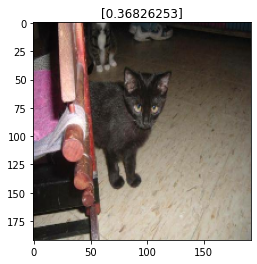

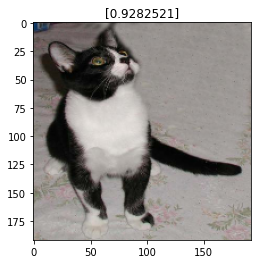

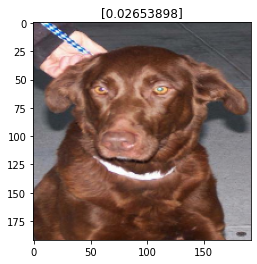

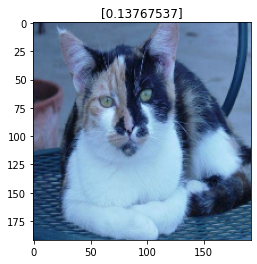

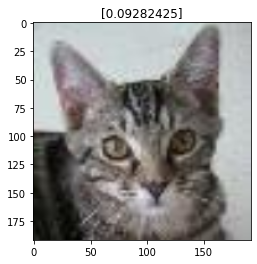

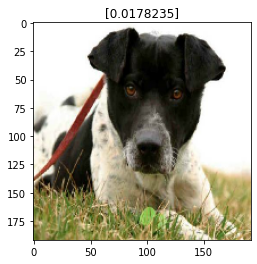

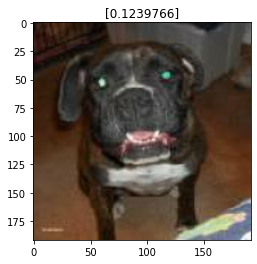

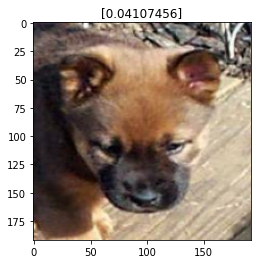

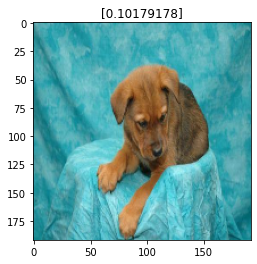

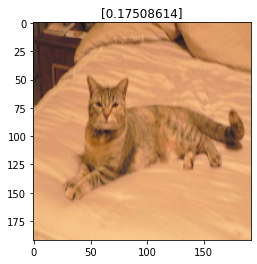

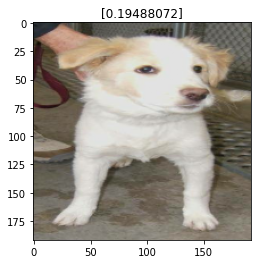

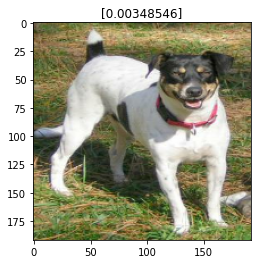

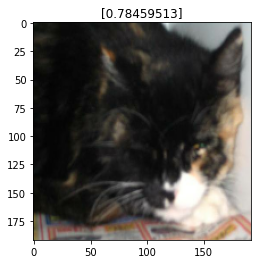

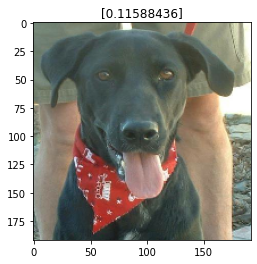

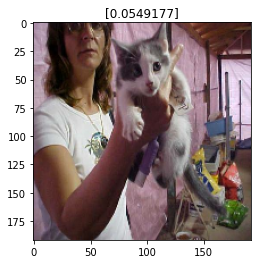

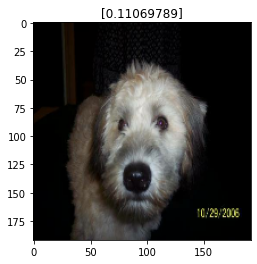

In [ ]:
for example, label in full_valid_ds.take(1):
    y_pred = model.predict(example)
  
    for i in range(len(y_pred)):
        plt.figure()
        plt.title(y_pred[i])
        plt.imshow(example[i])
    
plt.show()

* We'd like to know which predictions the model was most wrong about. To do this, we will define a `most_confused` function that will loop through all the batches in our validation dataset and output the highest MAE between the prediction and the actual value. 
 * As a reminder, the MAE (Mean Absolute Error): `np.abs(y_pred - y_true)`.

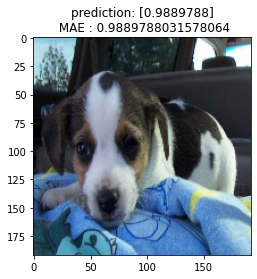

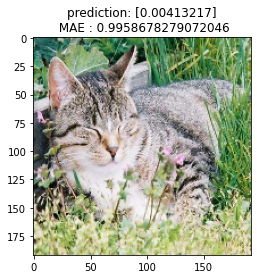

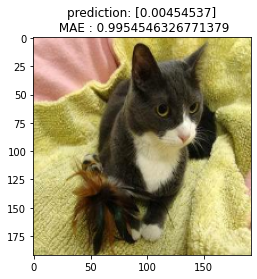

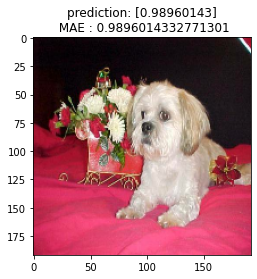

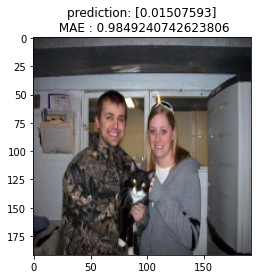

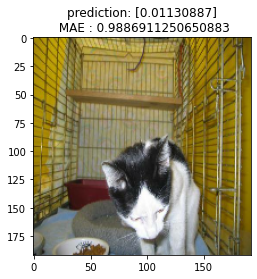

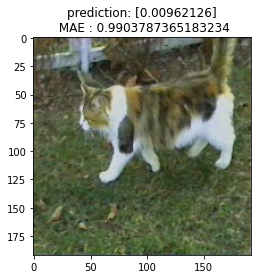

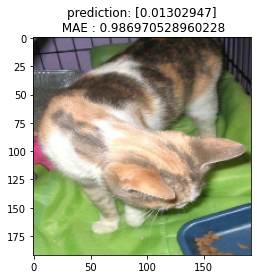

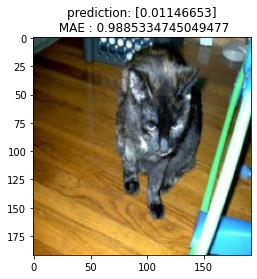

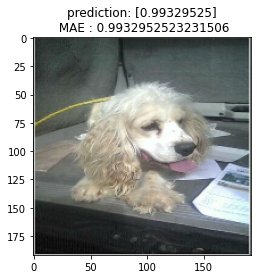

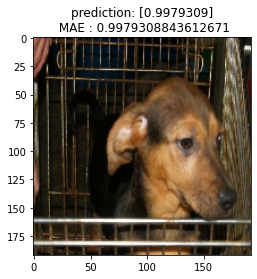

In [ ]:
def most_confused(full_valid_ds, threshold):
    for example, labels in full_valid_ds.take(-1):
        y_pred = model.predict(example)
        mae = np.abs(y_pred.squeeze() - labels.numpy().squeeze())

        for i in np.where(mae > threshold)[0]:
            plt.figure()
            plt.title("prediction: {}\n MAE : {}".format(y_pred[i], mae[i]))
            plt.imshow(example[i])

    plt.show()
  
most_confused(full_valid_ds, 0.98)

* Finally, we'd like to create a matrix of confusion to see where the model went wrong. It's going to happen in three stages: 
  * Create two empty lists: `y_true` & `y_pred`
  * Loop through your validation dataset and add the predictions for each batch to `y_pred` and the actual values to `y_true`.
  * Concatenate via [`tf.concat()`](https://www.tensorflow.org/api_docs/python/tf/concat) `y_pred` and `y_true` to have two tensors of `y_pred` and `y_true` of length 1000. 
  * Insert `y_pred` and `y_true` into a sklearn confusion matrix. 

In [ ]:
y_true = []
y_pred = []
for batch, true_labels in full_valid_ds.take(-1):
    y_true.append(true_labels.numpy())
    y_pred.append(model.predict_classes(batch))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
y_true = tf.concat(y_true, axis=0).numpy()
y_pred = tf.concat(y_pred, axis=0).numpy()

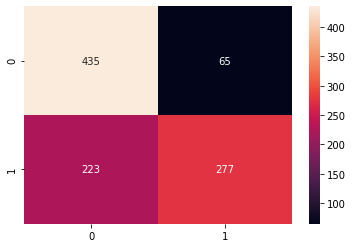

In [ ]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns 

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

---> We can find 73.4% accuracy that `model.evaluate` had shown us. This is better than what we could have had with a densely connected neural network! 